## Import packages for image processing and analysis

In [1]:
import os
import trackpy as tp
import pandas as pd
%matplotlib inline
from skimage import restoration
import copy
from oh_module import oh_functions as oh
from scipy.ndimage import gaussian_filter
from read_roi import read_roi_zip
tp.quiet()
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

## **(Optional)** Download test data set
Download test data including nd2_files and roi files from [Zenodo](https://doi.org/10.1101/2022.01.06.472721).

> **Note:** 
> If you have already downloaded the test data set and saved these files in an appropriately named folders, you do not need to perform the following step. Also, if you have your own nd2 files and roi data, you do not need to perform the following step.

> **Warning:** 
> Downloading data sets stored in Zenodo takes time.


In [2]:
input_dir = os.path.join('..', '')

# Download the test data set from Zenodo to input_dir.
!zenodo_get 10.5281/zenodo.7020499 -o $input_dir

# Unzip the downloaded zip files.
nd2_dir = os.path.join('..', 'nd2_files.zip')
roi_dir = os.path.join('..', 'roi.zip')
!unzip $nd2_dir -d $input_dir #unzip 
!unzip $roi_dir -d $input_dir #unzip

Title: Test dataset related to ST-tag analysis
Keywords: 
Publication date: 2022-08-26
DOI: 10.5281/zenodo.7020499
Total size: 328.7 MB

Link: https://zenodo.org/api/files/dffaa471-0b19-4a34-9198-2eb580e66715/nd2_files.zip   size: 328.7 MB
100% [..................................................] 344625732 / 344625732
Checksum is correct. (858618951edbd4d55ab669c546258eef)

Link: https://zenodo.org/api/files/dffaa471-0b19-4a34-9198-2eb580e66715/roi.zip   size: 0.0 MB
100% [..........................................................] 13619 / 13619
Checksum is correct. (73ffcbe1c7e70c01e7a212731848361c)
All files have been downloaded.
Archive:  ../nd2_files.zip
  inflating: ../nd2_files/BRD4-001.nd2  
  inflating: ../nd2_files/BRD4-002.nd2  
  inflating: ../nd2_files/BRD4-003.nd2  
  inflating: ../nd2_files/BRD4-004.nd2  
  inflating: ../nd2_files/BRD4-005.nd2  
  inflating: ../nd2_files/BRD4-006.nd2  
  inflating: ../nd2_files/BRD4-007.nd2  
  inflating: ../nd2_files/BRD4-008.nd2  
  inf

## Specify target directory for analysis
Specify the folder (including nd2_files and roi folders) that contains the data processed using Fiji.

In [3]:
input_dir = os.path.join('..', '')

## Perform image processing and image analysis
Read the ROI and image data determined by Fiji.
After image processing, the coordinates of mTetR and MCP spots were determined by local maxima. The spots were then subjected to Gauss fitting to determine the coordinates at the subpixel level. MCP spots within 390 nm of the mTetR spot with a relative fluorescence intensity greater than two-fold to the average intensity of the 19 × 19-pixel region of interest were classified as the “ON” state, and the remaining spots were classified as “OFF”. 

RefineException: ('Iteration limit reached',)
../roi/BRD4-003.nd2.zip
../roi/BRD4-013.nd2.zip
../roi/BRD4-025.nd2.zip
../roi/BRD4-035.nd2.zip
../roi/BRD4-034.nd2.zip
../roi/BRD4-024.nd2.zip
../roi/BRD4-012.nd2.zip
../roi/BRD4-002.nd2.zip


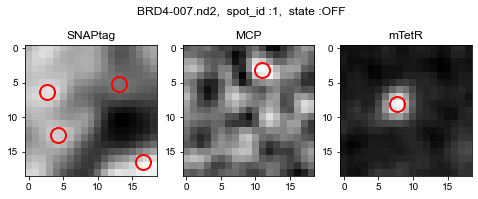

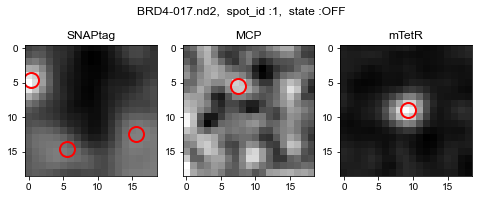

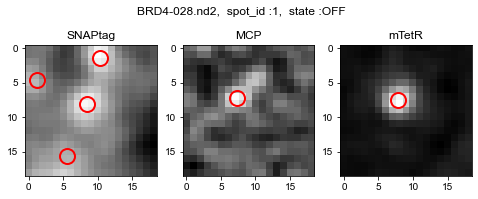

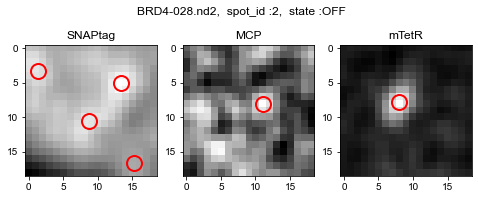

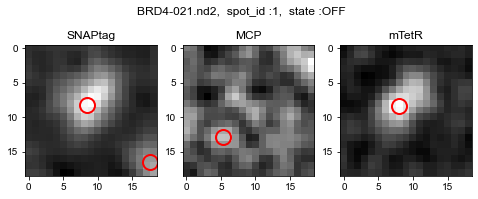

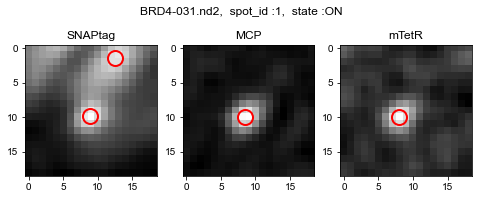

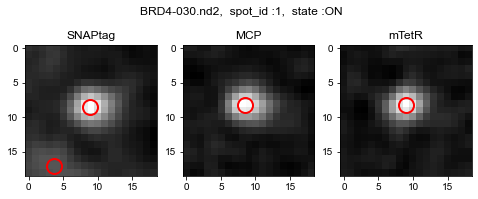

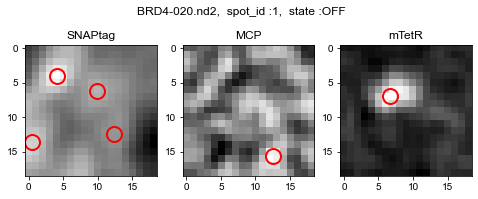

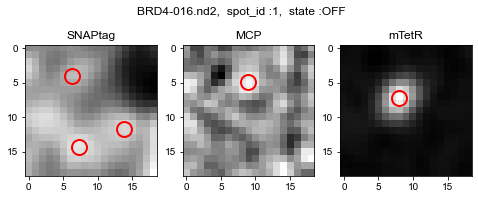

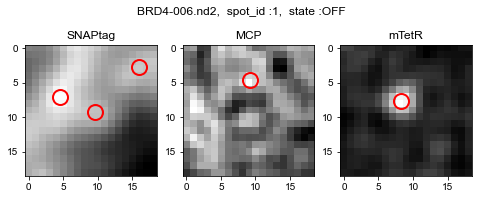

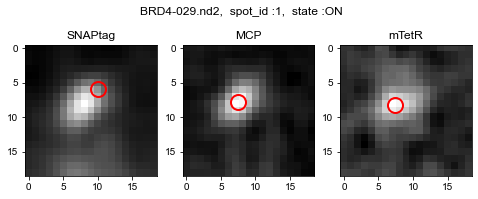

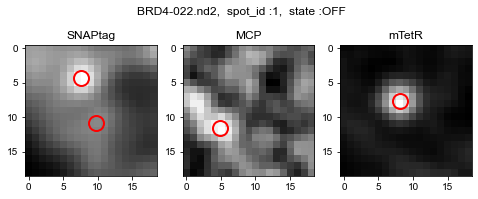

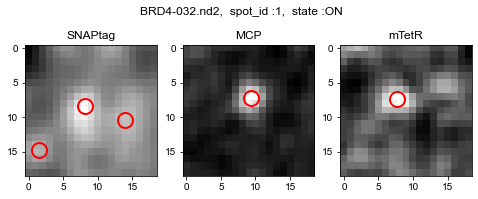

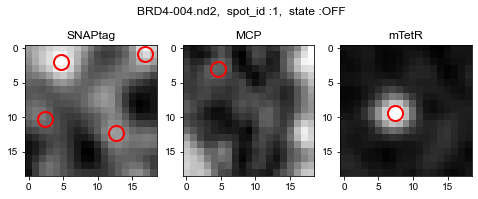

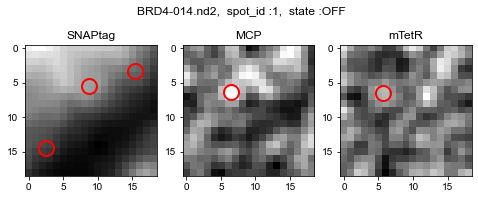

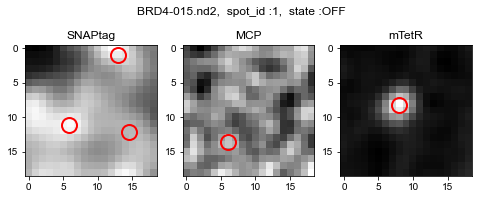

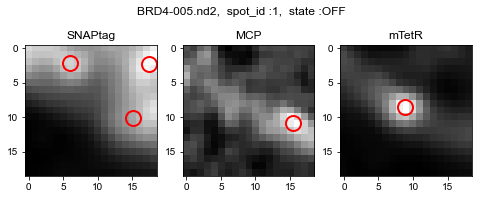

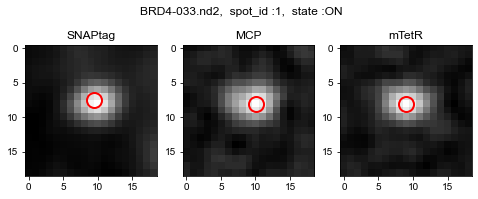

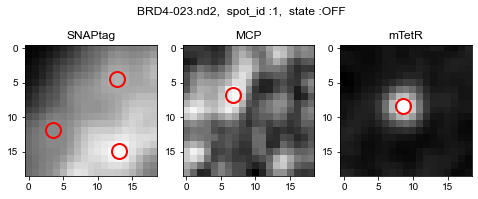

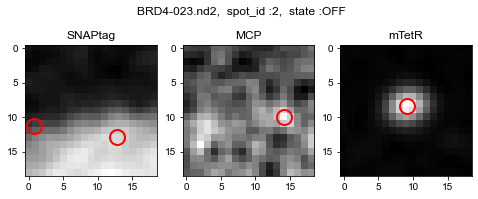

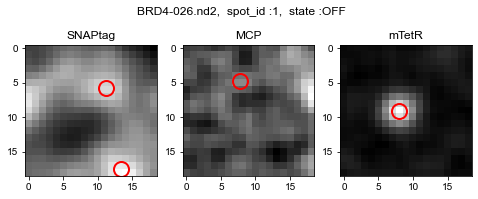

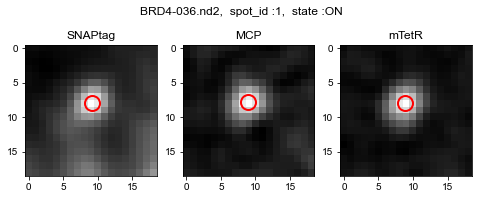

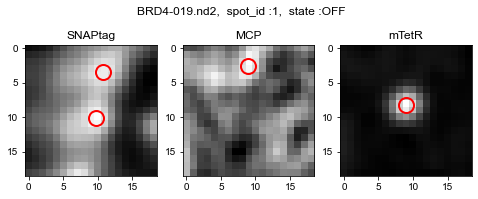

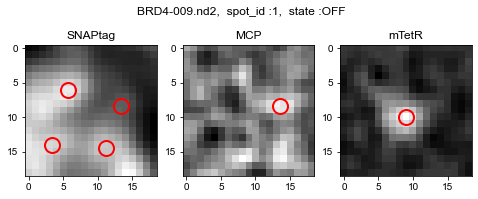

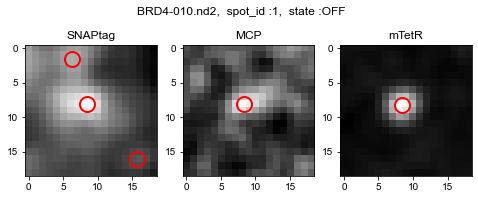

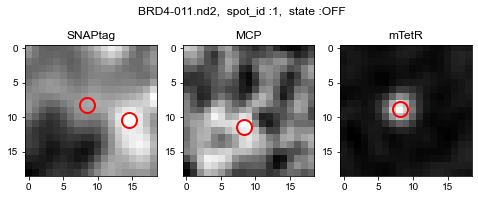

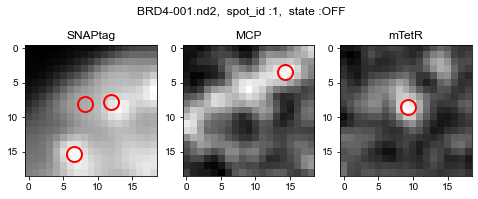

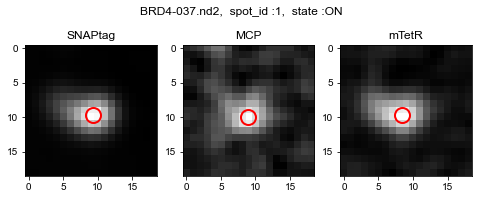

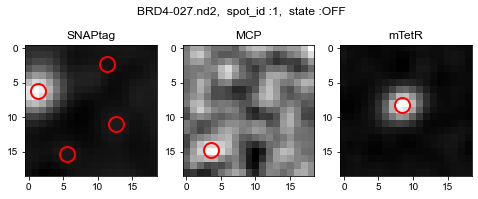

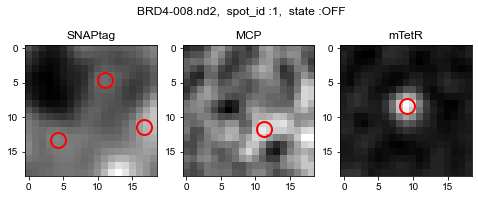

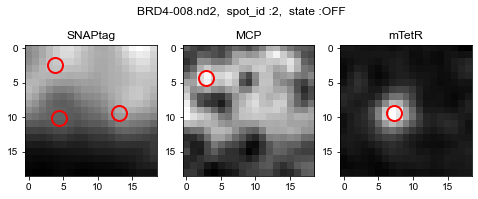

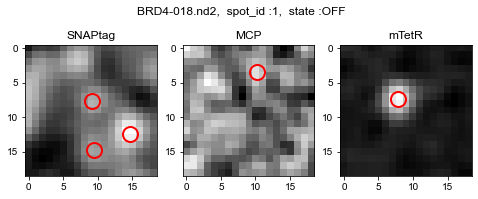

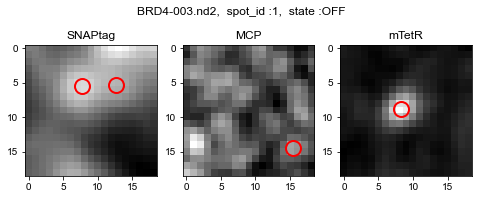

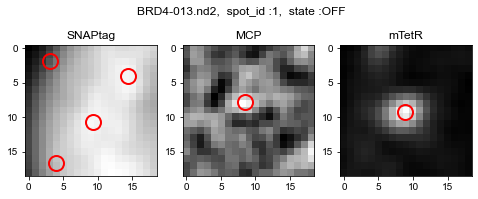

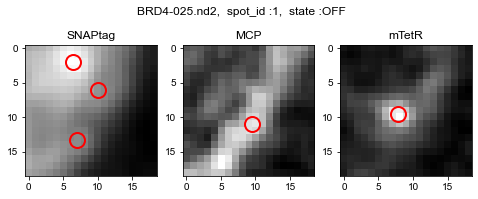

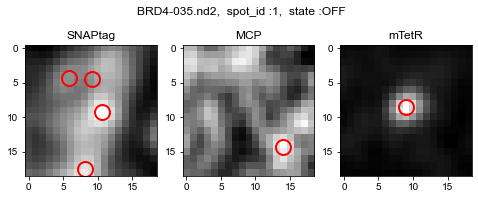

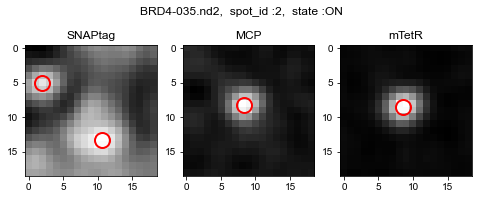

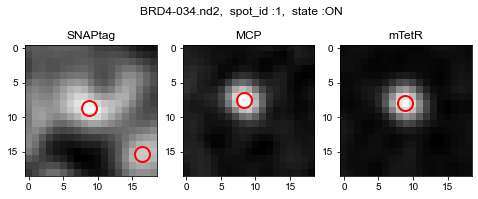

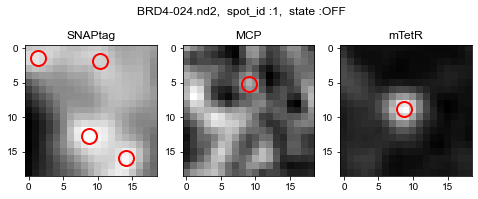

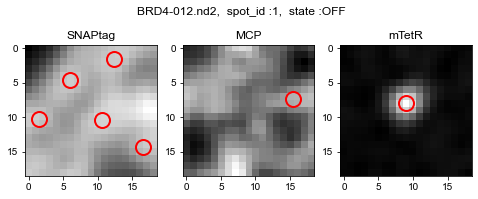

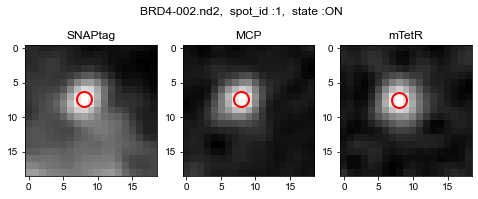

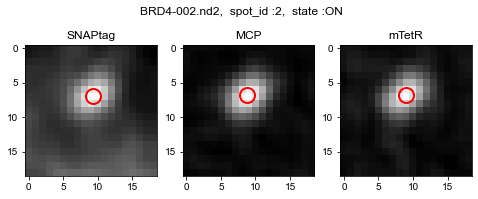

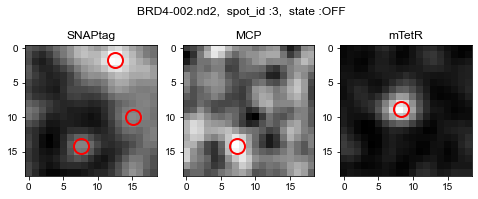

In [4]:
import glob

#Create an empty data frame (df_3_all).
df_3_all = pd.DataFrame()

#Obtain the ROI list in the ROI folder.
input_dir_a = os.path.join(input_dir, 'roi',"")
files = glob.glob(str(input_dir_a) + "*")

#Loop through the number of files.
for file in files:
    print(file)
    
    #Get information from the roi file.
    roi_file_path = file
    roi = read_roi_zip(roi_file_path)
    df_anno = oh.func_roi_to_df(roi)

    file_name_zip = file.replace(str(input_dir_a), '')
    file_name_nd2 = file_name_zip.replace('.zip', '')
    input_dir_b = os.path.join(input_dir, 'nd2_files',"")
    file_path = str(input_dir_b) + str(file_name_nd2)


    image_list = []
    
    #Loop through the number of colors.
    for color in range(3):
        #Get images from the nd2 file.
        img_o = oh.func_read_noFOV(file_path, 't', color)
        img_o = gaussian_filter(img_o, sigma = 1) #Apply a Gaussian filter to the image.
        if(color == 1 or color == 2): 
            background = [restoration.rolling_ball(img_o[i], radius = 5) for i in range(10)]
        else:
            background = [restoration.rolling_ball(img_o[i], radius = 50) for i in range(10)]
        output = img_o - background #Subtract the background.
        OUTPUT = output.mean(axis=0)

        image_list.append(OUTPUT) #Add images to image_list.

    #Give each spot an id in case there are multiple ROIs in each image.
    spot_id = 0

    #Loop through the number of ROIs in each image.
    for row in df_anno.itertuples():
        spot_id = spot_id + 1

        #Get a 19x19 pixel image centered on each ROI coordinate in each image.
        y_1 = int(row[1]) - 9
        y_2 = int(row[1]) + 10
        x_1 = int(row[2]) - 9
        x_2 = int(row[2]) + 10

        image_list_c = copy.copy(image_list)

        image_1 = image_list_c[0][y_1:y_2, x_1:x_2]
        image_2 = image_list_c[1][y_1:y_2, x_1:x_2]
        image_3 = image_list_c[2][y_1:y_2, x_1:x_2]


        #Create an area to display a graph with figure() and make it an object named fig.
        fig = plt.figure(figsize=(8,3))

        #Set the font in the graph.
        plt.rcParams["font.family"] = "Arial"
        
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)  
        ax3 = fig.add_subplot(133)  

        
        #Detect the center of spots in the SNAPtag image.
        df_1 = tp.locate(image_1, 5)
        df_1 = tp.refine_leastsq(df_1, image_1, 5, fit_function='gauss')
        df_1 = df_1.reset_index(drop=True)
        tp.annotate(df_1, image_1, ax = ax1)
        df_posi_1 = df_1.loc[:, ['y', 'x']]
        df_int_1 = oh.func_intensity(df_posi_1.values, image_1)
        df_1['r_snap'] = df_int_1['r_mass']
        #print (df_1)
        
        #Detect the center of spots in the MCP image.
        df_2 = tp.locate(image_2, 5, topn=1)
        df_2 = tp.refine_leastsq(df_2, image_2, 5, fit_function='gauss')
        df_2 = df_2.reset_index(drop=True)
        tp.annotate(df_2, image_2, ax = ax2)
        df_posi_2 = df_2.loc[:, ['y', 'x']]
        df_int_2 = oh.func_intensity(df_posi_2.values, image_2)
        df_2['r_mcp'] = df_int_2['r_mass']
        #print (df_2)
        
        #Detect the center of spots in the mTetR image.
        df_3 = tp.locate(image_3, 5, topn=1)
        df_3 = tp.refine_leastsq(df_3, image_3, 5, fit_function='gauss')
        df_3 = df_3.reset_index(drop=True)
        tp.annotate(df_3, image_3, ax = ax3)
        df_posi_3 = df_3.loc[:, ['y', 'x']]
        df_int_3 = oh.func_intensity(df_posi_3.values, image_3)
        df_3['r_tetr'] = df_int_3['r_mass']
        #print (df_int_3)
        #print (df_3)
        
        ax1.set_title('SNAPtag')
        ax2.set_title('MCP')
        ax3.set_title('mTetR')

        #Calculate the distance between the mTetR and SNAPtag spots.
        index, dist_s = oh.func_dis_min_2d(df_3['x'], df_3['y'], df_1['x'], df_1['y'])
        #print (dist_s)

        #Add data to df_3.
        df_3['dist_s_t'] = dist_s * 130 #Convert the unit of the distance between the mTetR and SNAPtag spots to nm.
        df_3['r_mcp'] = df_2['r_mcp'].values
        df_3['y_mcp'] = df_2['y'].values
        df_3['x_mcp'] = df_2['x'].values
        df_3['r_snap'] = df_1.iloc[index, -1]
        df_3['y_snap'] = df_1.iloc[index, 0]
        df_3['x_snap'] = df_1.iloc[index, 1]
        df_3['file_name'] = file_path
        df_3['spot_id'] = spot_id

        #Judge whether the MCP spot is ON or OFF state.
        if (len(df_2) > 0):
            index_m, dist_m = oh.func_dis_min_2d(df_3['x'], df_3['y'], df_2['x'], df_2['y'])
            df_3['dist_m_t'] = dist_m * 130
            if (df_2['r_mcp'].values >= 2 and dist_m <= 3):
                df_3['state'] = 'ON'
            else:
                df_3['state'] = 'OFF'
        else:
            df_3['state'] = 'OFF'

        #Add data to df_3_all.
        df_3_all = df_3_all.append(df_3)

        #Add title to the graph.
        plt.suptitle(file_name_nd2 + ",  spot_id :" + str(spot_id) + ",  state :" + df_3['state'].values[0])

## Import packages for diagram generation

In [5]:
## Initialize the index of df_3_all.
df_3_all = df_3_all.reset_index(drop=True)

##Assign '<370 nm' to df_3_all$threshold_dist
df_3_all['threshold_dist'] = '<370 nm'

##df_3_all$threshold_dist[df_3_all$dist_s_t>370] = '>370 nm'
df_3_all.loc[df_3_all['dist_s_t'] > 370, 'threshold_dist'] = '>370 nm'

##Import seaborn.
import seaborn as sns

from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator

## Boxplot showing 2D distances between mTetR spots and the nearest SNAPtag clusters in the ON and OFF states

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ON vs. OFF: p=1.74e-03


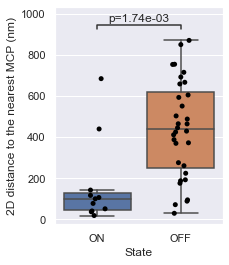

ON vs OFF: 
 MannwhitneyuResult(statistic=63.0, pvalue=0.001739454291341902) 

Data size : 
 state
OFF    32
ON     11
Name: y, dtype: int64 

Statistics of 2D distance to the nearest MCP (nm) at ON state : 
 count     11.000000
mean     164.699005
std      207.075385
min       18.445719
25%       45.905040
50%       99.892533
75%      129.328469
max      683.657010
Name: dist_s_t, dtype: float64 

Statistics of 2D distance to the nearest MCP (nm) at OFF state : 
 count     32.000000
mean     439.230409
std      235.378599
min       29.389039
25%      251.373225
50%      436.741766
75%      617.678756
max      869.589534
Name: dist_s_t, dtype: float64 



In [6]:
sns.set_theme() # Set seaborn theme.
sns.set(font='Arial') # Set seaborn font.
fig = plt.figure(figsize=(3,4)) # Set the size of the graph.
ax = fig.add_subplot(1, 1, 1) 
states_order = ['ON', 'OFF'] # Sort ON and OFF in order.
sns.boxplot(x = 'state', y = 'dist_s_t', data = df_3_all, ax = ax, showfliers=False, order=states_order) # Draw a boxplot.
sns.stripplot(x='state', y='dist_s_t', data=df_3_all, jitter=True, color='black', ax=ax, order=states_order) # Draw a stripplot.

ax.set_xlabel('State') #Change the x label of fig.
ax.set_ylabel('2D distance to the nearest MCP (nm)') #Change the y label of fig.

dist_s_t_ON = df_3_all.loc[(df_3_all.state == "ON"), "dist_s_t"].values
dist_s_t_OFF = df_3_all.loc[(df_3_all.state == "OFF"), "dist_s_t"].values


stat_results = [mannwhitneyu(dist_s_t_ON, dist_s_t_OFF, alternative="two-sided")] # Calculate the significant difference using Wilcoxon rank-sum test.

pvalues = [result.pvalue for result in stat_results] # Get p value.

pairs = [('ON', 'OFF')] # Specify the pairs of which to draw the significant difference.
annotator = Annotator(ax, pairs, x = 'state', y = 'dist_s_t', data = df_3_all, order=states_order) # Instantiate Annotator.

# Transform each p-value to "p=" in scientific notation
formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues] #Change the display format of p value.
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate() # Draw the significant difference.
  
plt.show()

#Display various statistics.
print("ON vs OFF: \n", stat_results[0], "\n")

print("Data size : \n" , df_3_all.groupby('state').count().iloc[:,0],"\n")

print("Statistics of 2D distance to the nearest MCP (nm) at ON state : \n" , df_3_all.loc[(df_3_all.state == "ON"), "dist_s_t"].describe(),"\n")
print("Statistics of 2D distance to the nearest MCP (nm) at OFF state : \n" , df_3_all.loc[(df_3_all.state == "OFF"), "dist_s_t"].describe(),"\n")





## CDF showing 2D distances between mTetR spots and the nearest SNAPtag clusters in the ON and OFF states

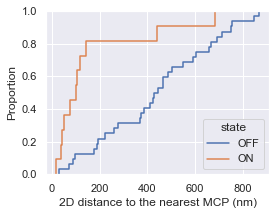

In [7]:
##Draw ecdfplot using seaborn.
sns.set_theme()
sns.set(font='Arial')
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1, 1, 1)

sns.ecdfplot(x = 'dist_s_t', data = df_3_all, hue = 'state', color = 'red', ax = ax) # Draw ecdfplot.

ax.set_xlabel('2D distance to the nearest MCP (nm)') #Change the x label of fig.
sns.move_legend(ax, "lower right")

## Relative mTetR-RF-cluster xy coordinates

Text(0, 0.5, 'Relative y coordinate (µm)')

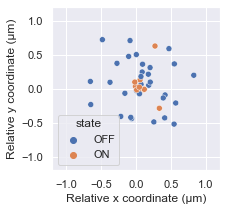

In [8]:
#Calculate the relative coordinate of SNAPtag spots against mTetR spots.
df_3_all['y_t.s'] = df_3_all['y_snap'] - df_3_all['y']
df_3_all['x_t.s'] = df_3_all['x_snap'] - df_3_all['x']

##Convert relative coordinate to µm.
df_3_all['y_t.s_µm'] = df_3_all['y_t.s'] * 0.13
df_3_all['x_t.s_µm'] = df_3_all['x_t.s'] * 0.13


sns.set_theme()
sns.set(font='Arial')

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1, 1, 1)

##Draw scatter plot using seaborn.
sns.scatterplot(x = 'x_t.s_µm', y = 'y_t.s_µm', data = df_3_all, hue = 'state', ax=ax)
plt.ylim(-1.2,1.2) #Set the range of y axis.
plt.xlim(-1.2,1.2) #Set the range of x axis.

ax.set_xlabel('Relative x coordinate (µm)')
ax.set_ylabel('Relative y coordinate (µm)')

## Boxplot showing distributions of MCP fluorescence intensities at the mTetR spot with the 2D distance between the mTetR spot and nearest SNAPtag cluster at <370 and >370 nm

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

>370 nm vs. <370 nm: p=7.67e-03


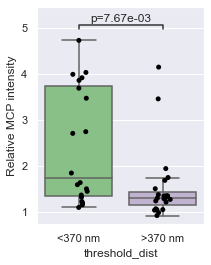

ON vs OFF: 
 MannwhitneyuResult(statistic=340.0, pvalue=0.007670456430055729) 

Data size : 
 threshold_dist
<370 nm    20
>370 nm    23
Name: y, dtype: int64 

Statistics of Relative MCP intensity at ON state : 
 count    20.000000
mean      2.419350
std       1.249109
min       1.089999
25%       1.347935
50%       1.733652
75%       3.726034
max       4.722569
Name: r_mcp, dtype: float64 

Statistics of Relative MCP intensity at OFF state : 
 count    23.000000
mean      1.513622
std       0.767890
min       0.913654
25%       1.132761
50%       1.300181
75%       1.432910
max       4.141646
Name: r_mcp, dtype: float64 



In [9]:
##Drawing a boxplot in seaborn.
sns.set_theme()
sns.set(font='Arial')

fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(1, 1, 1)

threshold_dist_order = ['<370 nm', '>370 nm'] # Sort <350 nm and >350 nm in order.

sns.boxplot(x = 'threshold_dist', y = 'r_mcp', data = df_3_all, palette = 'Accent', ax=ax, showfliers=False, order=threshold_dist_order)
sns.stripplot(x='threshold_dist', y='r_mcp', data=df_3_all, jitter=True, color='black', ax=ax, order=threshold_dist_order)

ax.set_ylabel('Relative MCP intensity')

r_mcp_less = df_3_all.loc[(df_3_all.threshold_dist == '<370 nm'), "r_mcp"].values
r_mcp_more = df_3_all.loc[(df_3_all.threshold_dist == '>370 nm'), "r_mcp"].values

stat_results = [mannwhitneyu(r_mcp_less, r_mcp_more, alternative="two-sided")]

pvalues = [result.pvalue for result in stat_results]


pairs = [('<370 nm', '>370 nm')] 
annotator = Annotator(ax, pairs, x = 'threshold_dist', y = 'r_mcp', data = df_3_all)

# Transform each p-value to "p=" in scientific notation
formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate()

plt.show()



print("ON vs OFF: \n", stat_results[0], "\n")

print("Data size : \n" , df_3_all.groupby('threshold_dist').count().iloc[:,0],"\n")

print("Statistics of Relative MCP intensity at ON state : \n" , df_3_all.loc[(df_3_all.threshold_dist == '<370 nm'), "r_mcp"].describe(),"\n")
print("Statistics of Relative MCP intensity at OFF state : \n" , df_3_all.loc[(df_3_all.threshold_dist == '>370 nm'), "r_mcp"].describe(),"\n")

## CDF showing distributions of MCP fluorescence intensities at the mTetR spot with the 2D distance between the mTetR spot and nearest SNAPtag cluster at <370 and >370 nm

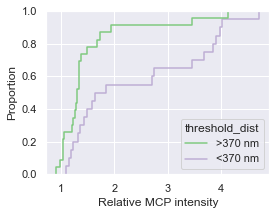

In [10]:
#Draw ecdfplot using seaborn.
sns.set_theme()
sns.set(font='Arial')
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1, 1, 1)

sns.ecdfplot(x = 'r_mcp', data = df_3_all, hue = 'threshold_dist', color = 'red', ax=ax, palette = 'Accent')
ax.set_xlabel('Relative MCP intensity')
sns.move_legend(ax, "lower right")